https://www.kaggle.com/arunava21/word2vec-and-random-forest-classification#word2vec-and-random-forest-classification

In [1]:
from gensim.models import Word2Vec, word2vec
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import sqlite3
import re
from tqdm import tqdm


In [2]:
logging.basicConfig(level=logging.INFO)
%matplotlib inline

In [3]:
# Load the punkt tokenizer used for splitting reviews into sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [4]:
connection = sqlite3.connect('/home/jeremy/data/database.sqlite')
reviews = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", connection)
connection.close()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f6c3b6240>]],
      dtype=object)

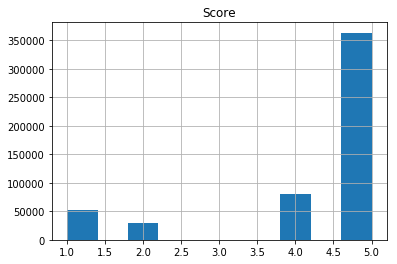

In [5]:
reviews.hist('Score')

In [6]:
reviews['Class'] = 1 * (reviews['Score'] > 3)

In [7]:
reviews.sort_values('ProductId', axis=0, inplace=True)

In [8]:
train_size = int(len(reviews) * 0.5)
train_reviews = reviews.iloc[:train_size,:]
test_reviews = reviews.iloc[train_size:,:]

In [9]:
test_remove = np.logical_or(test_reviews['ProductId'].isin(train_reviews['ProductId']),
                          test_reviews['UserId'].isin(train_reviews['UserId']))
test_reviews = test_reviews[np.logical_not(test_remove)]

In [10]:
print('Training set contains {:d} reviews.'.format(len(train_reviews)))
print('Test set contains {:d} reviews ({:d} removed).'.format(len(test_reviews), sum(test_remove)))

Training set contains 262907 reviews.
Test set contains 151198 reviews (111709 removed).


In [11]:
n_pos_train = sum(train_reviews['Class'] == 1)
print('Training set contains {:.2%} positive reviews'.format(n_pos_train/len(train_reviews)))
n_pos_test = sum(test_reviews['Class'] == 1)
print('Test set contains {:.2%} positive reviews'.format(n_pos_test/len(test_reviews)))

Training set contains 84.93% positive reviews
Test set contains 82.37% positive reviews


In [12]:
del reviews  # hint for garbage collection

In [13]:
def review_to_wordlist(review, remove_stopwords=False):
    """
    Convert a review to a list of words. Removal of stop words is optional.
    """
    # remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    
    # convert to lower case and split at whitespace
    words = review_text.lower().split()
    
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words

In [14]:
def review_to_sentences(review, tokenizer, remove_stopwords=False):
    """
    Split review into list of sentences where each sentence is a list of words.
    Removal of stop words is optional.
    """
    # use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())

    # each sentence is furthermore split into words
    sentences = []    
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
            
    return sentences

In [15]:
train_sentences = []  # Initialize an empty list of sentences
for review in train_reviews['Text']:
    train_sentences += review_to_sentences(review, tokenizer)

In [16]:
train_sentences[0]

['this',
 'witty',
 'little',
 'book',
 'makes',
 'my',
 'son',
 'laugh',
 'at',
 'loud']

In [17]:
model_name = 'train_word2vec_model'
# Set values for various word2vec parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 3       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words
if not os.path.exists(model_name): 
    # Initialize and train the model (this will take some time)
    model = word2vec.Word2Vec(train_sentences, workers=num_workers, \
                size=num_features, min_count = min_word_count, \
                window = context, sample = downsampling)

    # If you don't plan to train the model any further, calling 
    # init_sims will make the model much more memory-efficient.
    model.init_sims(replace=True)

    # It can be helpful to create a meaningful model name and 
    # save the model for later use. You can load it later using Word2Vec.load()
    model.save(model_name)
else:
    model = Word2Vec.load(model_name)



INFO:gensim.utils:loading Word2Vec object from train_word2vec_model
INFO:gensim.utils:loading wv recursively from train_word2vec_model.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:loading vocabulary recursively from train_word2vec_model.vocabulary.* with mmap=None
INFO:gensim.utils:loading trainables recursively from train_word2vec_model.trainables.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:loaded train_word2vec_model


In [18]:
del train_sentences

In [19]:
model.doesnt_match("banana apple orange sausage".split())

/home/jeremy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors
/home/jeremy/miniconda3/lib/python3.6/site-packages/gensim-3.4.0-py3.6-linux-x86_64.egg/gensim/models/keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'sausage'

In [20]:
model.most_similar("great")

/home/jeremy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('fantastic', 0.7966971397399902),
 ('terrific', 0.7931782007217407),
 ('wonderful', 0.7777034044265747),
 ('fabulous', 0.7204808592796326),
 ('good', 0.7067806720733643),
 ('awesome', 0.671294093132019),
 ('excellent', 0.6547362804412842),
 ('superb', 0.6331993341445923),
 ('phenomenal', 0.630683958530426),
 ('perfect', 0.6228036880493164)]

In [21]:
# model.syn0.shape

In [64]:
def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.wv.index2word)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec,model[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec


def get_avg_feature_vecs(reviews, model, num_features):
    """
    Calculate average feature vectors for all reviews
    """
    counter = 0.
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')  # pre-initialize (for speed)
    for review in reviews:
        review_feature_vecs[int(counter)] = make_feature_vec(review, model, num_features)
#         review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1.
    return review_feature_vecs

In [65]:
# calculate average feature vectors for training and test sets
clean_train_reviews = []
for review in train_reviews['Text'][:10]:
    clean_train_reviews.append(review_to_wordlist(review, remove_stopwords=True))
    

In [66]:
    
trainDataVecs = get_avg_feature_vecs(clean_train_reviews[0:10], model, num_features)

/home/jeremy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [26]:
trainDataVecs.shape

(10, 300)

In [27]:
clean_test_reviews = []
for review in test_reviews['Text'][:10]:
    clean_test_reviews.append(review_to_wordlist(review, remove_stopwords=True))
testDataVecs = get_avg_feature_vecs(clean_test_reviews, model, num_features)

counter = 0.0
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
counter = 1.0
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
counter = 2.0
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
counter = 3.0
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
counter = 4.0
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
counter = 5.0
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
counter = 6.0
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
counter = 7.0
only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (

/home/jeremy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [29]:
# Fit a random forest to the training data, using 100 trees
forest = RandomForestClassifier(n_estimators = 100)

print("Fitting a random forest to labeled training data...")
forest = forest.fit(trainDataVecs, train_reviews['Class'][:10])

Fitting a random forest to labeled training data...


In [30]:
# remove instances in test set that could not be represented as feature vectors
nan_indices = list({x for x,y in np.argwhere(np.isnan(testDataVecs))})
if len(nan_indices) > 0:
    print('Removing {:d} instances from test set.'.format(len(nan_indices)))
    testDataVecs = np.delete(testDataVecs, nan_indices, axis=0)
    test_reviews.drop(test_reviews.iloc[nan_indices, :].index, axis=0, inplace=True)
    assert testDataVecs.shape[0] == len(test_reviews)


In [31]:
print("Predicting labels for test data..")
result = forest.predict(testDataVecs)

Predicting labels for test data..


In [34]:
print(classification_report(test_reviews['Class'][:10], result))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.80      1.00      0.89         8

    accuracy                           0.80        10
   macro avg       0.40      0.50      0.44        10
weighted avg       0.64      0.80      0.71        10



/home/jeremy/miniconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jeremy/miniconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jeremy/miniconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
probs = forest.predict_proba(testDataVecs)

In [ ]:
probs = forest.predict_proba(testDataVecs)[:, 1]

In [41]:
fpr, tpr, _ = roc_curve(test_reviews['Class'][:10], probs)
auc = roc_auc_score(test_reviews['Class'][:10], probs)

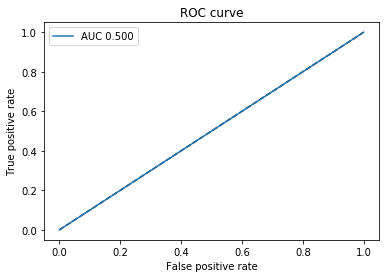

In [42]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
